In [73]:
import torch 
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path

import depth_estimation
from depth_estimation.depth_anything_v2.dpt import DepthAnythingV2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Path to the root of the project
root_path = Path('/home/artem-trybushenko/Projects/depth-estimation/')

weights_path_dict = {
    'vits': root_path / 'tmp/2024-11-16-depth-anything-weights/depth-anything-v2/vits/depth_anything_v2_vits.pth',
    'vitb': root_path / 'tmp/2024-11-16-depth-anything-weights/depth-anything-v2/vitb/depth_anything_v2_vitb.pth',
    'vitl': root_path / 'tmp/2024-11-16-depth-anything-weights/depth-anything-v2/vitl/depth_anything_v2_vitl.pth',
}

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': (48, 96, 192, 384)},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': (96, 192, 384, 768)},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': (256, 512, 1024, 1024)},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': (1536, 1536, 1536, 1536)}
}

data_path = root_path / 'tmp/2024-11-16-images-to-inference/'

In [63]:
def load_depth_anything_v2_model(weights_path: Path, model_configs: dict, model_type: str = 'vits', device: str = 'cuda') -> DepthAnythingV2:
    model = DepthAnythingV2(
        encoder=model_configs[model_type]['encoder'],
        features=model_configs[model_type]['features'],
        out_channels=model_configs[model_type]['out_channels']
    )
    state_dict = torch.load(weights_path, map_location='cpu', weights_only=True)
    model.load_state_dict(state_dict, strict=True)
    model.eval()
    model = model.to(device)
    return model

model_type = 'vitl'
model = load_depth_anything_v2_model(weights_path_dict[model_type], model_configs, model_type, device)

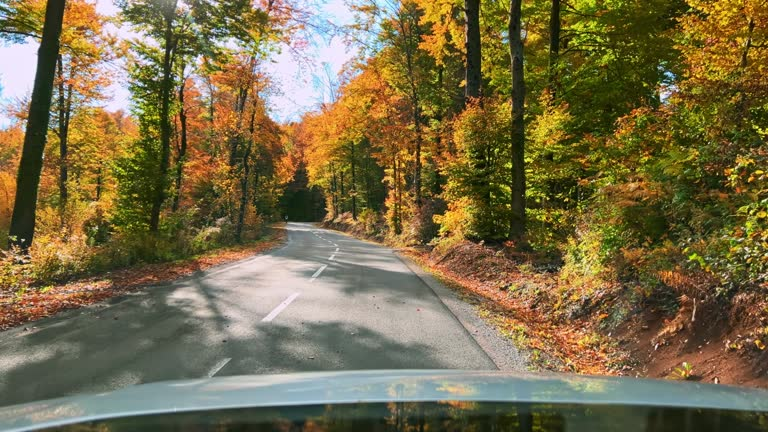

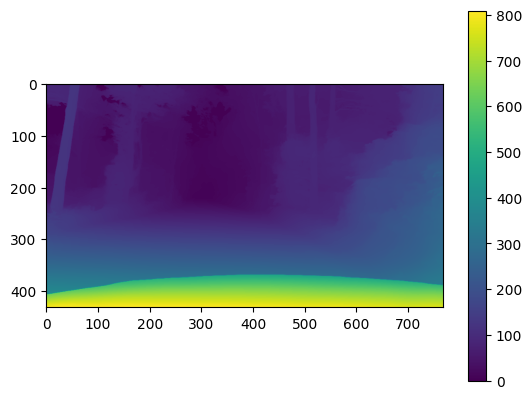

In [74]:
@torch.no_grad()
def make_prediction_depth_anything_v2(model, image, device):
    processed_image, processed_shape = model.image2tensor(image)
    processed_image = processed_image.to(device)
    prediction = model(processed_image)
    return prediction

def plot_depth_heatmap(depth_map, original_shape):
    depth_map_resized = torch.nn.functional.interpolate(depth_map.unsqueeze(0), size=original_shape, mode='bilinear', align_corners=False)
    plt.imshow(depth_map_resized.squeeze().cpu().numpy(), cmap='viridis')
    plt.colorbar()
    plt.show()

image = Image.open(np.random.choice(list(data_path.glob('*.jpg')))).convert('RGB')
display(image)
depth_map = make_prediction_depth_anything_v2(model, np.array(image), device)
plot_depth_heatmap(depth_map, image.size[::-1])

In [75]:
depth_map

tensor([[[ 92.1223,  90.7336,  91.9640,  ..., 145.2449, 145.9396, 130.1620],
         [ 92.5269,  91.7042,  92.5398,  ..., 145.1283, 145.8908, 145.4359],
         [ 91.9562,  91.9685,  91.7743,  ..., 142.3422, 144.3289, 144.9950],
         ...,
         [783.3124, 786.7778, 786.9383,  ..., 754.9365, 756.2466, 754.8560],
         [790.9468, 791.3460, 792.8716,  ..., 760.7551, 760.4125, 759.7220],
         [795.5096, 794.8411, 794.0860,  ..., 762.6110, 764.8644, 766.8389]]],
       device='cuda:0')

In [6]:
from PIL import Image
import numpy as np
np.array(Image.open('/home/artem-trybushenko/Projects/depth-estimation/tmp/2024-11-16-images-to-inference/D519_264_066_0004_600.jpg').convert('RGB')).shape

(338, 600, 3)

In [1]:
import torch